#### required libraries

In [62]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

#### dataset location

In [63]:
insurance_df_loc = 'data/learning_from_imbalanced_insurance_data/aug_train.csv'

#### reading data

In [64]:
insurance_df = pd.read_csv(insurance_df_loc).set_index('id')
# insurance_df.head()

In [65]:
print(insurance_df.shape)

(382154, 11)


#### checking for non-numerical data

In [66]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382154 entries, 167647 to 401019
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                382154 non-null  object 
 1   Age                   382154 non-null  int64  
 2   Driving_License       382154 non-null  int64  
 3   Region_Code           382154 non-null  float64
 4   Previously_Insured    382154 non-null  int64  
 5   Vehicle_Age           382154 non-null  object 
 6   Vehicle_Damage        382154 non-null  object 
 7   Annual_Premium        382154 non-null  float64
 8   Policy_Sales_Channel  382154 non-null  float64
 9   Vintage               382154 non-null  int64  
 10  Response              382154 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 35.0+ MB


In [67]:
insurance_df['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     200176
< 1 Year     166353
> 2 Years     15625
Name: count, dtype: int64

In [68]:
insurance_df['Gender'].value_counts()

Gender
Male      205603
Female    176551
Name: count, dtype: int64

In [69]:
insurance_df['Vehicle_Damage'].value_counts()

Vehicle_Damage
No     198501
Yes    183653
Name: count, dtype: int64

#### one-hot-encoding

- all can be one-hot-encoded

In [70]:
insurance_df = pd.get_dummies(insurance_df, drop_first=True)

In [71]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 382154 entries, 167647 to 401019
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Age                    382154 non-null  int64  
 1   Driving_License        382154 non-null  int64  
 2   Region_Code            382154 non-null  float64
 3   Previously_Insured     382154 non-null  int64  
 4   Annual_Premium         382154 non-null  float64
 5   Policy_Sales_Channel   382154 non-null  float64
 6   Vintage                382154 non-null  int64  
 7   Response               382154 non-null  int64  
 8   Gender_Male            382154 non-null  bool   
 9   Vehicle_Age_< 1 Year   382154 non-null  bool   
 10  Vehicle_Age_> 2 Years  382154 non-null  bool   
 11  Vehicle_Damage_Yes     382154 non-null  bool   
dtypes: bool(4), float64(3), int64(5)
memory usage: 27.7 MB


#### correlation heatmap

<Axes: >

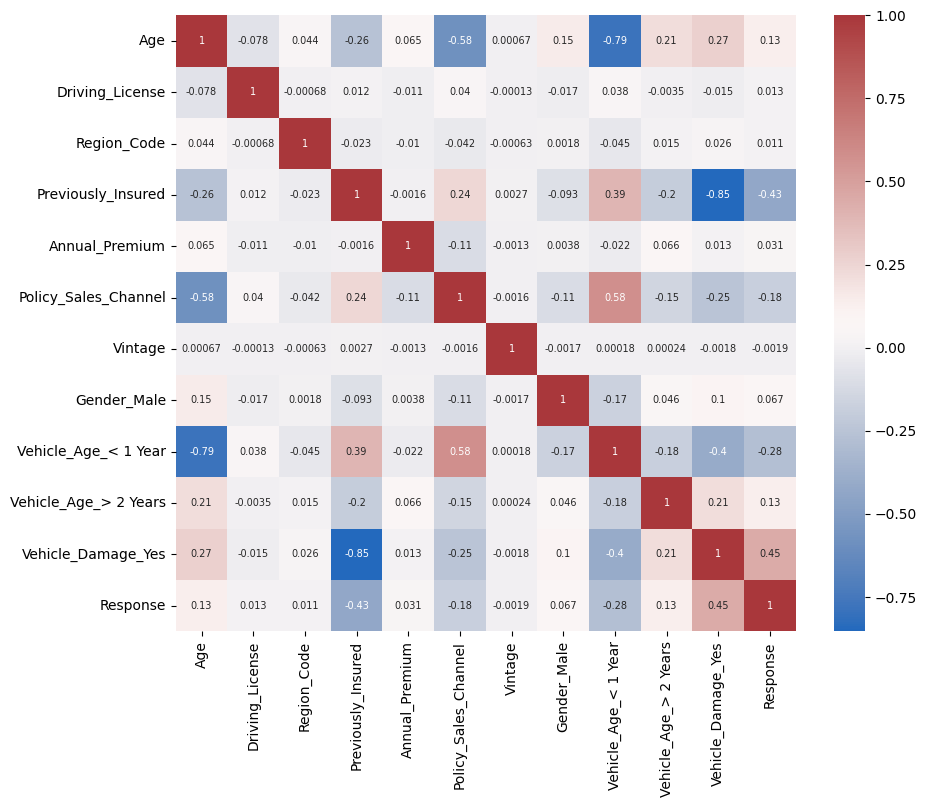

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.concat([insurance_df.drop('Response', axis=1), insurance_df['Response']], axis=1).corr(), annot=True, annot_kws={"size": 7}, cmap='vlag') 

#### let's check class imbalanceness

- since this is a competition no target variable('Response') is provided for the test set

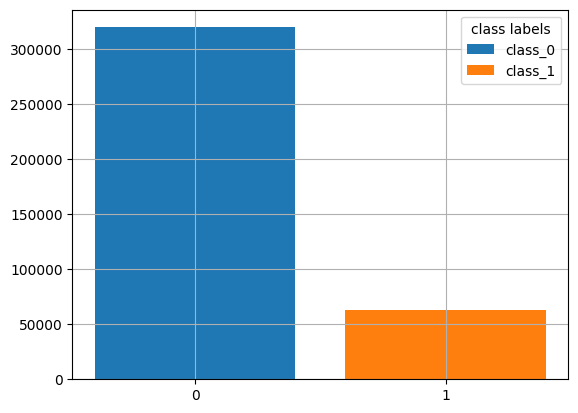

In [73]:
target_0s = (insurance_df['Response'] == 0).sum()
target_1s = (insurance_df['Response'] == 1).sum()

plt.bar([0, 1], [target_0s, target_1s], label=['class_0', 'class_1'], color=['tab:blue', 'tab:orange'])
plt.xticks([0, 1])
plt.legend(["class_0", "class_1"], title='class labels')
plt.grid()
plt.show()

#### check for empty cells (imputation)

In [74]:
print('null in train set:\n',
      insurance_df.isna().sum().sort_values(),
      '\n\nnull in test set:\n',
      insurance_df.isna().sum().sort_values())

null in train set:
 Age                      0
Driving_License          0
Region_Code              0
Previously_Insured       0
Annual_Premium           0
Policy_Sales_Channel     0
Vintage                  0
Response                 0
Gender_Male              0
Vehicle_Age_< 1 Year     0
Vehicle_Age_> 2 Years    0
Vehicle_Damage_Yes       0
dtype: int64 

null in test set:
 Age                      0
Driving_License          0
Region_Code              0
Previously_Insured       0
Annual_Premium           0
Policy_Sales_Channel     0
Vintage                  0
Response                 0
Gender_Male              0
Vehicle_Age_< 1 Year     0
Vehicle_Age_> 2 Years    0
Vehicle_Damage_Yes       0
dtype: int64


- no imputation is needed because no null values

#### train test split

In [75]:
X = insurance_df.drop('Response', axis=1)
y = insurance_df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#### feature importance

In [76]:
logreg = LogisticRegression()

param_grid = {'C': np.arange(0.01, 0.1, 0.01)}
logreg_gcv = GridSearchCV(logreg, param_grid=param_grid)

stdscl = StandardScaler()
X_train_scal = stdscl.fit_transform(X_train)

logreg_gcv.fit(X_train_scal, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])})

- best parameter alpha based on grid search

In [77]:
print(logreg_gcv.best_score_, logreg_gcv.best_params_)

0.8350990937937202 {'C': 0.08}


c:\Users\Eshan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[-3.41101687e-02 -1.34235502e-01 -8.72399358e-03 -2.18216615e+00
 -5.17997147e-06 -5.77894887e-03  1.38016547e-05  1.69910061e-01
 -1.02265561e+00  2.26595329e-01  2.13903181e+00]


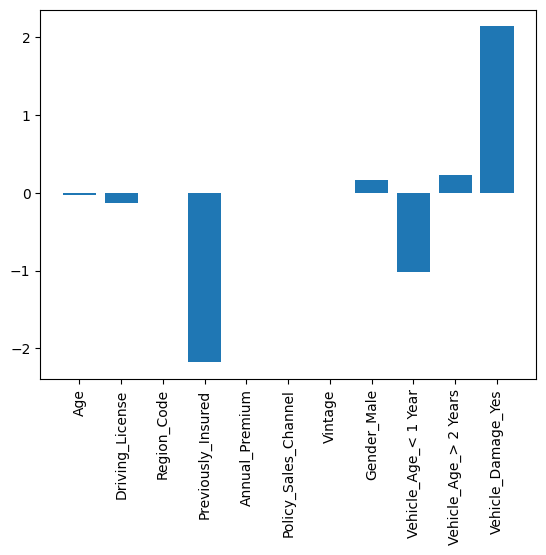

In [78]:
logreg_best = LogisticRegression(C=0.08)
logreg_best.fit(X_train, y_train)

logreg_coef = logreg_best.coef_

print(logreg_coef[0])

columns = X_train.columns

plt.bar(columns, logreg_coef[0])
plt.xticks(rotation=90)
plt.show()

- drop unnecessary features

In [79]:
X_train = X_train.drop(['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'], axis=1)
X_test = X_test.drop(['Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'], axis=1)

In [80]:
print(X_train.columns.to_list())

['Age', 'Driving_License', 'Previously_Insured', 'Gender_Male', 'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_Yes']


#### scaling and centering the data

- scaling is needed when doing SMOT to reduce the dispropotions.
- easy to train ml model

1. standardization
    - subtract mean and devide by variance
    - all features are centered around zero having variance of one

2. Normalization
    - subtract minimum and divide by range (max-min)
    - scaled features have minimum = 0, maximum = 1
    - also can normalize between -1 and +1

In [81]:
X_train.describe()

,Age,Driving_License,Previously_Insured
count,305723.000000,305723.000000,305723.000000
mean,38.527101,0.998126,0.489168
std,15.209446,0.043252,0.499883
min,20.000000,0.000000,0.000000
25%,25.000000,1.000000,0.000000
50%,36.000000,1.000000,0.000000
75%,49.000000,1.000000,1.000000
max,85.000000,1.000000,1.000000


- standerdization

In [82]:
stdscl = StandardScaler()
X_train_scaled = stdscl.fit_transform(X_train)
X_test_scaled = stdscl.transform(X_test)

#### model selection

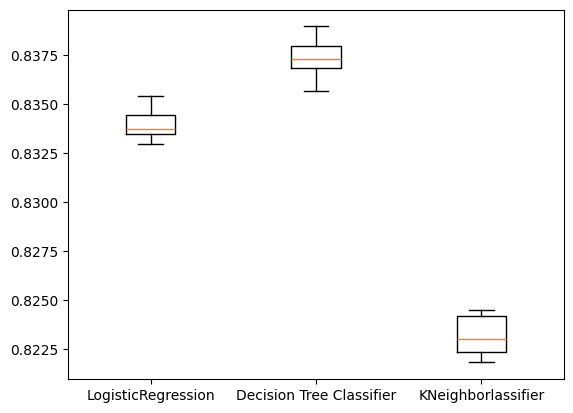

In [83]:
models = {"LogisticRegression": LogisticRegression(),
          "Decision Tree Classifier": DecisionTreeClassifier(),
          "KNeighborlassifier": KNeighborsClassifier()}

results = []

# Loop through the models' values
for model in models.values():
  kf = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

#### decision tree hyperparameter tuning

In [84]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

In [85]:
decision_tree = DecisionTreeClassifier()
decision_tree_gcv = GridSearchCV(decision_tree, param_grid=param_grid)
decision_tree_gcv.fit(X_train_scaled, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]})

In [86]:
print(decision_tree_gcv.best_score_, decision_tree_gcv.best_params_)

0.8380625614506594 {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


#### without undersampling techniques

In [87]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=10)
cv_score = cross_val_score(decision_tree, X_train_scaled, y_train, cv=kf, scoring='recall')

In [88]:
print(cv_score)

[0.12639776 0.17292332 0.17029347 0.14576677 0.15615016 0.16853035
 0.22783546 0.13498403 0.16693291 0.17192492]


- Fit the model to train set

In [89]:
decision_tree.fit(X_train_scaled, y_train)
y_pred = decision_tree.predict(X_test_scaled)
y_prob = decision_tree.predict_proba(X_test_scaled)[:, 0]

- evaluation matics

              precision    recall  f1-score   support

           0       0.85      0.97      0.91     63911
           1       0.50      0.16      0.24     12520

    accuracy                           0.84     76431
   macro avg       0.68      0.56      0.58     76431
weighted avg       0.80      0.84      0.80     76431

[[61919  1992]
 [10517  2003]]
0.878669931648659


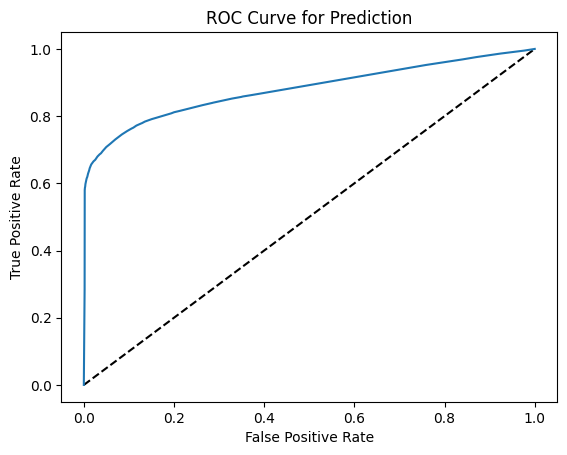

In [90]:
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(roc_auc_score(y_test, 1-y_prob))

tpr, fpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Prediction')
plt.show()

#### undersampling

1. SMOTE

In [91]:
smote = SMOTE(sampling_strategy='minority', k_neighbors=5)
X_train_oversampled, y_train = smote.fit_resample(X_train_scaled, y_train)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=10)
cv_score = cross_val_score(decision_tree, X_train_oversampled, y_train, cv=kf, scoring='recall')

In [92]:
print(cv_score)

[0.92055234 0.91930058 0.92618815 0.92552318 0.92825849 0.92763261
 0.91992646 0.91570177 0.91843999 0.92657644]


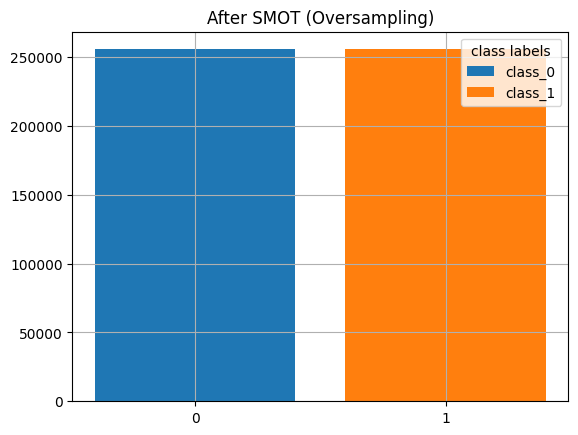

In [93]:
target_0s = (y_train == 0).sum()
target_1s = (y_train == 1).sum()

plt.bar([0, 1], [target_0s, target_1s], label=['class_0', 'class_1'], color=['tab:blue', 'tab:orange'])
plt.xticks([0, 1])
plt.legend(["class_0", "class_1"], title='class labels')
plt.title('After SMOT (Oversampling)')
plt.grid()
plt.show()

- Fit the model to train set

In [94]:
decision_tree.fit(X_train_oversampled, y_train)
y_pred = decision_tree.predict(X_test_scaled)
y_prob = decision_tree.predict_proba(X_test_scaled)[:, 0]

- evaluation matics

              precision    recall  f1-score   support

           0       0.98      0.74      0.84     63911
           1       0.41      0.92      0.57     12520

    accuracy                           0.77     76431
   macro avg       0.69      0.83      0.70     76431
weighted avg       0.89      0.77      0.80     76431

[[47219 16692]
 [  972 11548]]
0.8785342591282215


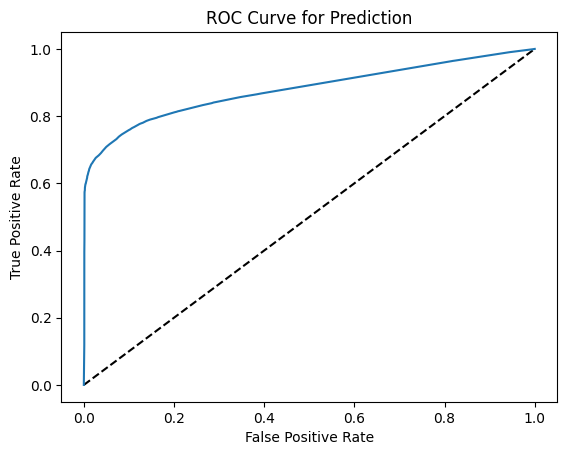

In [95]:
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(roc_auc_score(y_test, 1-y_prob))

tpr, fpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Prediction')
plt.show()